# Project 1: Trump, Twitter, and Text

Welcome to the first project of DS100! In this project, we will work with the Twitter API in order to analyze Donald Trump's tweets.

**The project checkpoint is due 11:59pm Tuesday, Sept. 26.** The checkpoint is graded on *completeness*, not correctness. You must complete Questions 1-4 in order to get full credit for the checkpoint.

**The entire project is due 11:59pm Tuesday, Oct 3.**

*Fair warning:* This project involves significantly more challenging pandas operations than the previous homeworks. We strongly suggest you start early.

**Grading:**

The checkpoint is worth **10%** of the overall project grade and is graded on completeness.

However, the final submission of the project will be graded on **correctness**.

**Fun:**

We intended this project to be fun! You will analyze actual data from the Twitter API — no precooked dataset this time around. You will also draw conclusions about the current (and often controversial) US President's tweet behavior. If you find yourself getting frustrated or stuck on one problem for too long, we suggest coming into office hours and working with friends in the class.

With that in mind, let's get started!

In [2]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

from IPython.display import display, Latex, Markdown
from client.api.notebook import Notebook
ok = Notebook('proj1.ok')

Assignment: Project 1
OK, version v1.12.10



In [2]:
# Log into OkPy. You may have to change this to ok.auth(force=True) if you run into
# an OAuthError
ok.auth(force=True)


Open the following URL:

https://okpy.org/client/login/

After logging in, copy the code from the web page and paste it into the box.
Then press the "Enter" key on your keyboard.

Paste your code here: 0m6EIAe9RkIbztFRW8FM1I82MFknEt
Successfully logged in as mattholtzer9@berkeley.edu



<br/><br/><br/>

# Getting the dataset

---

Since we'll be looking at Twitter data, we need to download the data from Twitter!

Twitter provides an API for downloading tweet data in large batches.  The `tweepy` package makes it fairly easy to use.

#### Setup
Install `tweepy`, if you don't already have it.  (Be sure to activate your Conda environment for the class first.  Then run `pip install tweepy`.)

In [6]:
## Make sure you are in your ds100 conda environment.
## Uncomment the following line to install tweepy
!pip install tweepy

In [7]:
# The following should run
import tweepy

There are instructions on using `tweepy` [here](http://tweepy.readthedocs.io/en/v3.5.0/getting_started.html), but we will give you example code.

Twitter requires you to have authentication keys to access their API.  To get your keys, you'll have to sign up as a Twitter developer.  The next question will walk you through this process.

---
<br/><br/>

## Question 1

Follow the instructions below to get your Twitter API keys.  Read the instructions completely before starting.

1. [Create a Twitter account](https://twitter.com).  You can use an existing account if you have one.
2. Under account settings, add your phone number to the account.
3. [Create a Twitter developer account](https://dev.twitter.com/resources/signup).  Attach it to your Twitter account.
4. Once you're logged into your developer account, [create an application for this assignment](https://apps.twitter.com/app/new).  You can call it whatever you want, and you can write any URL when it asks for a web site.
5. On the page for that application, find your Consumer Key and Consumer Secret.
6. On the same page, create an Access Token.  Record the resulting Access Token and Access Token Secret.
7. Edit the file [keys.json](keys.json) and replace the placeholders with your keys.  Don't turn in that file.


## WARNING (Please Read) !!!!


### Protect your Twitter Keys
<span style="color:red">
If someone has your authentication keys, they can access your Twitter account and post as you!  So don't give them to anyone, and **don't write them down in this notebook**. 
</span>
The usual way to store sensitive information like this is to put it in a separate file and read it programmatically.  That way, you can share the rest of your code without sharing your keys.  That's why we're asking you to put your keys in `keys.json` for this assignment.


### Avoid making too many API calls.

<span style="color:red">
Twitter limits developers to a certain rate of requests for data.  If you make too many requests in a short period of time, you'll have to wait awhile (around 15 minutes) before you can make more.  </span> 
So carefully follow the code examples you see and don't rerun cells without thinking.  Instead, always save the data you've collected to a file.  We've provided templates to help you do that.


### Be careful about which functions you call!

<span style="color:red">
This API can retweet tweets, follow and unfollow people, and modify your twitter settings.  Be careful which functions you invoke! </span> One of your instructors accidentally re-tweeted some tweets because that instructor typed `retweet` instead of `retweet_count`. 
</span>


In [8]:
import json
key_file = 'keys.json'
# Loading your keys from keys.json (which you should have filled
# in in question 1):
with open(key_file) as f:
    keys = json.load(f)

# if you print or view the contents of keys be sure to delete the cell!

This cell tests the Twitter authentication. It should run without errors or warnings and display your Twitter username.

In [9]:
import tweepy
from tweepy import TweepError
import logging

try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

Your username is: madiwantsbagels


---
<br/><br/>


## Question 2

In the example below, we have loaded some tweets by @BerkeleyData.  Run it and read the code.

In [10]:
from pathlib import Path

ds_tweets_save_path = "BerkeleyData_recent_tweets.pkl"
# Guarding against attempts to download the data multiple
# times:
if not Path(ds_tweets_save_path).is_file():
    # Obtaining twitter keys
    import json
    key_file = 'keys.json'
    # Loading your keys from keys.json (which you should have filled
    # in in question 1):
    with open(key_file) as f:
        keys = json.load(f)
    
    # Authenticating:
    import tweepy
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)

    # Getting as many recent tweets by @BerkeleyData as Twitter will let us have:
    example_tweets = list(tweepy.Cursor(api.user_timeline, id="BerkeleyData").items())

    # Saving the tweets to a file as "pickled" objects:
    with open(ds_tweets_save_path, "wb") as f:
        import pickle
        pickle.dump(example_tweets, f)

# Re-loading the results:
with open(ds_tweets_save_path, "rb") as f:
    import pickle
    example_tweets = pickle.load(f)

Assuming everything ran correctly you should be able to look at the first tweet by running the cell below:

In [11]:
# Looking at one tweet object, which has type Status: 
from pprint import pprint # ...to get a more easily-readable view.
#pprint(example_tweets[0]._json)

### What you need to do. 

Re-factor the above code fragment into reusable snippets below.  You should not need to make major modifications; this is mostly an exercise in understanding the above code block. 

In [12]:
def load_keys(path):
    """Loads your Twitter authentication keys from a file on disk.
    
    Args:
        path (str): The path to your key file.  The file should
          be in JSON format and look like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
          key values."""
    import json
    with open(path) as f:
        hey = json.load(f)
    return hey

In [13]:
def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user.

    Args:
        user_account_name (str): The name of the Twitter account
          whose tweets will be downloaded.
        keys (dict): A Python dictionary with Twitter authentication
          keys (strings), like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }

    Returns:
        list: A list of Status objects, each representing one tweet."""
    import tweepy
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    example_tweets = list(tweepy.Cursor(api.user_timeline, id=user_account_name).items())
    return example_tweets

In [14]:
def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.  (That means you can implement this function however
    you want, as long as saving and loading works!)

    Args:
        tweets (list): A list of tweet objects (of type Status) to
          be saved.
        path (str): The place where the tweets will be saved.

    Returns:
        None"""
    with open(path, "wb") as f:
        import pickle
        pickle.dump(tweets, f)

In [15]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Status objects, each representing one tweet."""
    with open(path, "rb") as f:
        import pickle
        example_tweets = pickle.load(f)
    return example_tweets

In [16]:
def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    The first time you call this function, it will download tweets by
    a user.  Subsequent calls will not re-download the tweets; instead
    they'll load the tweets from a save file in your local filesystem.
    All this is done using the functions you defined in the previous cell.
    This has benefits and drawbacks that often appear when you cache data:
    
    +: Using this function will prevent extraneous usage of the Twitter API.
    +: You will get your data much faster after the first time it's called.
    -: If you really want to re-download the tweets (say, to get newer ones,
       or because you screwed up something in the previous cell and your
       tweets aren't what you wanted), you'll have to find the save file
       (which will look like <something>_recent_tweets.pkl) and delete it.
    
    Args:
        user_account_name (str): The Twitter handle of a user, without the @.
        keys_path (str): The path to a JSON keys file in your filesystem.
    """
    tweets_save_path = user_account_name + "_recent_tweets.pkl"
    if not Path(tweets_save_path).is_file():
        keys = load_keys(keys_path)
        tweets = download_recent_tweets_by_user(user_account_name, keys)
        save_tweets(tweets, tweets_save_path)
    return load_tweets(tweets_save_path)

If everything was implemented correctly you should be able to obtain roughly the last 3000 tweets by the `realdonaldtrump`.

In [17]:
# When you are done, run this cell to load @realdonaldtrump's tweets.
# Note the function get_tweets_with_cache.  You may find it useful
# later.
trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

Number of tweets downloaded: 3234


---
<br/><br/>

## Question 3

In this question you will extract important fields from the tweet objects and convert them into a Pandas dataframe for further analysis.

Each trump tweet is stored in a `tweepy.models.Status` object:

In [18]:
type(trump_tweets[0])

tweepy.models.Status

We can list all the members of this object by looking at the private `__dict__` variable:

In [19]:
list(trump_tweets[0].__dict__.keys())

['_json',
 'created_at',
 'id',
 'id_str',
 'text',
 'truncated',
 'entities',
 'source',
 'source_url',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name',
 'author',
 'user',
 'geo',
 'coordinates',
 'place',
 'contributors',
 'is_quote_status',
 'retweet_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'lang']

Therefore we can extract a field simply by reading its value:

In [20]:
trump_tweets[0].text

'A big day for the U.S. at the United Nations!'

In [21]:
[j.created_at for j in trump_tweets]

[datetime.datetime(2017, 9, 21, 22, 26, 29),
 datetime.datetime(2017, 9, 21, 22, 23, 44),
 datetime.datetime(2017, 9, 21, 17, 58, 30),
 datetime.datetime(2017, 9, 21, 16, 6, 32),
 datetime.datetime(2017, 9, 21, 15, 17, 42),
 datetime.datetime(2017, 9, 21, 15, 15, 19),
 datetime.datetime(2017, 9, 21, 3, 13, 7),
 datetime.datetime(2017, 9, 21, 1, 6, 25),
 datetime.datetime(2017, 9, 21, 0, 42, 17),
 datetime.datetime(2017, 9, 20, 23, 7, 55),
 datetime.datetime(2017, 9, 20, 22, 42, 35),
 datetime.datetime(2017, 9, 20, 22, 29, 44),
 datetime.datetime(2017, 9, 20, 19, 9, 58),
 datetime.datetime(2017, 9, 20, 19, 5, 18),
 datetime.datetime(2017, 9, 20, 17, 8, 53),
 datetime.datetime(2017, 9, 20, 15, 23, 46),
 datetime.datetime(2017, 9, 20, 12, 29, 1),
 datetime.datetime(2017, 9, 20, 12, 16, 22),
 datetime.datetime(2017, 9, 20, 12, 9, 54),
 datetime.datetime(2017, 9, 20, 11, 3, 31),
 datetime.datetime(2017, 9, 20, 11, 0, 34),
 datetime.datetime(2017, 9, 20, 10, 47, 35),
 datetime.datetime(2017,

### What you need to do

Construct a DataFrame called `trump`. The index of the dataframe should be the ID of each tweet (looks something like `907698529606541312`). It should have these columns:

- `time`: The time the tweet was created.
- `source`: The source device of the tweet.
- `text`: The text of the tweet.
- `retweet_count`: The retweet count of the tweet. 

In [22]:
trump = pd.DataFrame(
    data = {
        'time': [j.created_at for j in trump_tweets],
        'source': [j.source for j in trump_tweets],
        'text': [j.text for j in trump_tweets],
        'retweet_count': [j.retweet_count for j in trump_tweets]
    },
    index = [j.id_str for j in trump_tweets]
)

In [23]:
'907698529606541312' in trump.index

True

In [24]:
_ = ok.grade('q03')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: mattholtzer9@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/VOG3O5
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



Here are two important dates that we'll use in our analysis. `ELEC_DATE` is the date when Trump won the 2016 Presidential election, and `INAUG_DATE` is the date that Trump was sworn into office.

In [25]:
from datetime import datetime

ELEC_DATE = datetime(2016, 11, 8)
INAUG_DATE = datetime(2017, 1, 20)

Here are the first and last rows of your tweet data.

You'll notice that the data contains tweets from before the election.

In [26]:
trump.iloc[[0, -1], :]

retweet_count              source  \
910993665568526337           8467  Twitter for iPhone   
757618048664829952          12696  Twitter for iPhone   

                                                                 text  \
910993665568526337      A big day for the U.S. at the United Nations!   
757618048664829952  #MakeAmericaGreatAgain \nhttps://t.co/EXsoUOsE...   

                                  time  
910993665568526337 2017-09-21 22:26:29  
757618048664829952 2016-07-25 16:46:33

## Question 4: Tweet Source Analysis

In the following questions, we are going to find out the charateristics of Trump tweets and the devices used for the tweets.

---
<br/><br/>

## Question 4a

Find out the number of unique sources of the Trump tweets. Save the result in `num_sources`. 

Then, make a bar plot of the counts of different sources.

In [27]:
len(trump['source'].value_counts())

7

In [28]:
trump['source'].value_counts().index

Index(['Twitter for iPhone', 'Twitter for Android', 'Twitter Web Client',
       'Media Studio', 'Twitter Ads', 'Twitter for iPad', 'Periscope'],
      dtype='object')

In [1]:
trump['source'].value_counts()

NameError: name 'trump' is not defined

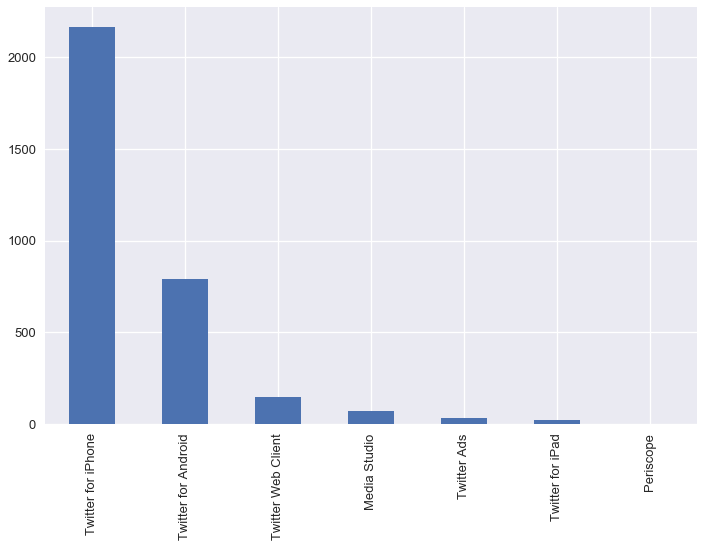

In [30]:
num_sources = len(trump['source'].value_counts())

# make a bar plot here
trump['source'].value_counts().plot(kind = 'bar')

In [31]:
_ = ok.grade('q04a')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: mattholtzer9@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/YEL3E0
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



As we can see from the plot above, Trump tweets are mostly from iPhone or Android. Is there a difference between his Tweet behavior between the two devices?

We will attempt to answer this question in our subsequent analysis.

First, we'll take a look at whether Trump's tweets from an Android come at different times than his tweets from an iPhone. Note that Twitter gives us his tweets in the [UTC timezone](https://www.wikiwand.com/en/List_of_UTC_time_offsets):

In [32]:
print(trump_tweets[0]._json['created_at'])

Thu Sep 21 22:26:29 +0000 2017


We'll convert the tweet times to US Eastern Time, the timezone of New York and Washington D.C., since those are the places we would expect the most tweet activity from Trump.

In [33]:
trump['est_time'] = pd.Index(trump['time']).tz_localize("UTC").tz_convert("US/Eastern")
trump.head()

retweet_count              source  \
910993665568526337           8467  Twitter for iPhone   
910992971620864004           4533  Twitter for iPhone   
910926223684931585          13297        Media Studio   
910898047931912192           7126        Media Studio   
910885755320459264           4954  Twitter for iPhone   

                                                                 text  \
910993665568526337      A big day for the U.S. at the United Nations!   
910992971620864004  Senator Luther Strange has gone up a lot in th...   
910926223684931585  Today, I announced a new Executive Order with ...   
910898047931912192  It was a great privilege to meet with Presiden...   
910885755320459264  It was wonderful to have President Petro Poros...   

                                  time                  est_time  
910993665568526337 2017-09-21 22:26:29 2017-09-21 18:26:29-04:00  
910992971620864004 2017-09-21 22:23:44 2017-09-21 18:23:44-04:00  
910926223684931585 2017-09-21 17:58:30 2017-09-21 13:58:30-04:00  
910898047931912192 2017-09-21 16:06:32 2017-09-21 12:06:32-04:00  
910885755320459264 2017-09-21 15:17:42 2017-09-21 11:17:42-04:00

---
<br/><br/>

## Question 4b

Use this data to make a line plot with two curves:

1. The number of iPhone tweets vs. hour of the day, normalized over the hours of the day. For example, if there were 10 tweets at 1pm and 20 tweets at 2pm, the line plot should be 0, then 0.33 at 1pm, 0.66 at 2pm, then back to 0.
2. The same curve for Android tweets.

Put the two curves in the same plot. You should get a plot that looks like:

![](device_hour.png)

Hint: use `value_counts` with `normalization`

In [34]:
trump['hour'] = trump['est_time'].dt.hour

In [35]:
trump.loc[trump['source']=='Twitter for iPhone']['hour'].value_counts(normalize = True).sort_index().index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64')

In [36]:
partial_trump = pd.DataFrame(
    data = {
        'iPhone' : trump.loc[trump['source']=='Twitter for iPhone']['hour'].value_counts(normalize = True).sort_index(),
        'Android' : trump.loc[trump['source']=='Twitter for Android']['hour'].value_counts(normalize = True).sort_index(),
        'hour': trump.loc[trump['source']=='Twitter for iPhone']['hour'].value_counts(normalize = True).sort_index().index
    }
)
partial_trump.head()


Android  hour    iPhone
0  0.012610     0  0.015697
1  0.006305     1  0.006925
2  0.002522     2  0.001847
3  0.001261     3  0.003232
4       NaN     4  0.001385

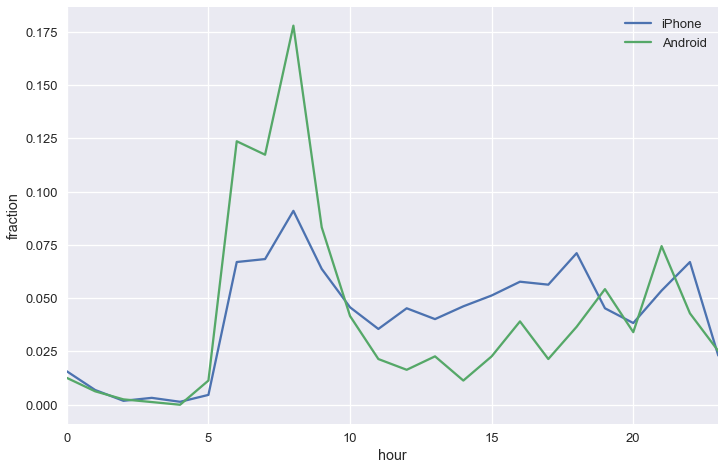

In [37]:
### make your plot here
partial_trump.fillna(0).plot('hour', ['iPhone', 'Android']).set_ylabel("fraction")

--- 
<br></br>

## Question 4c
What can you find out in the plot?

In [38]:
q4c_answer = r"""

We can find that while they both follow similar trends they do show some places where they split. During the morning,
5-10 AM, tweets are significantly more likely to come from his Android. During the daytime, 10 AM - 6 PM, tweets are
more likely to come from his iPhone.

"""

display(Markdown(q4c_answer))



We can find that while they both follow similar trends they do show some places where they split. During the morning,
5-10 AM, tweets are significantly more likely to come from his Android. During the daytime, 10 AM - 6 PM, tweets are
more likely to come from his iPhone.



--- 
<br></br>

Let's now look at his tweet device usage over the entire time period we have in the dataset.

Take a look at the code below and the plot it generates.

You should be answer the following questions about this code. You don't have to write the answers down anywhere, but you'll need to make variations of this plot in later questions so understanding this code will help you greatly.

1. What does `set_index` do here?
1. What does `resample` do? What does the `'D'` argument do in `resample`?
1. What does `unstack` do? What does the `level=0` argument do in unstack?
1. Why does one call to `plot()` generate 7 lines?

Feel free to copy this cell, play around with the code to see the intermediate result, then delete your cell after you're done.

(**Also, all the questions in this project can be answered using this style of method chaining.** If you write `for` loops in this project, know that there is a better way.)

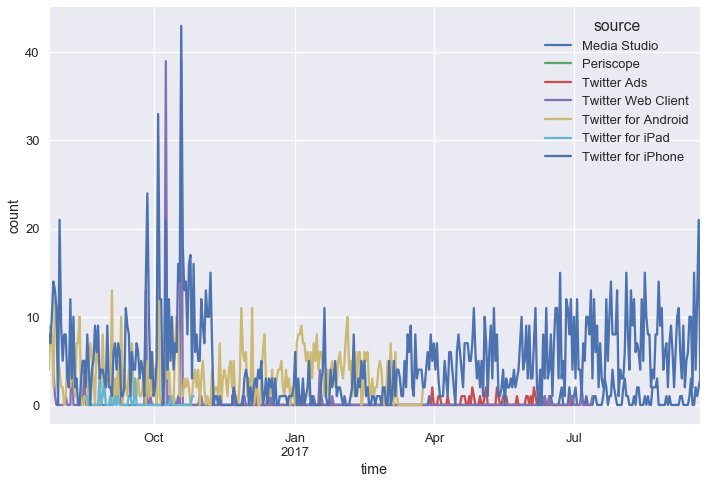

In [39]:
(trump.loc[:, ['est_time', 'source']]
 .set_index('est_time')
 .groupby('source')
 .resample('D')
 .size()
 .unstack(level=0)
 .plot()
)
plt.xlabel('time')
plt.ylabel('count')

## Question 4d

One problem with the plot above is that it plots too many points to see overall trends in the device usage.

Recreate the plot above, grouping by each month instead of each day. You may want to use the `figsize` argument to `plot` to make your plot larger.

In [40]:
trump['month'] = trump['est_time'].dt.month

In [41]:
(trump.loc[:, ['est_time', 'source']]
 .set_index('est_time')
 .groupby('source')
 .resample('M')
 .size()
 .unstack(level=0))

source                     Media Studio  Periscope  Twitter Ads  \
est_time                                                          
2016-07-31 00:00:00-04:00           NaN        NaN          NaN   
2016-08-31 00:00:00-04:00           NaN        NaN          NaN   
2016-09-30 00:00:00-04:00           1.0        NaN          NaN   
2016-10-31 00:00:00-04:00           0.0        NaN          NaN   
2016-11-30 00:00:00-05:00           0.0        1.0          1.0   
2016-12-31 00:00:00-05:00           0.0        NaN          0.0   
2017-01-31 00:00:00-05:00           0.0        NaN          0.0   
2017-02-28 00:00:00-05:00           0.0        NaN          0.0   
2017-03-31 00:00:00-04:00           1.0        NaN          2.0   
2017-04-30 00:00:00-04:00           0.0        NaN         10.0   
2017-05-31 00:00:00-04:00           0.0        NaN         12.0   
2017-06-30 00:00:00-04:00           7.0        NaN          9.0   
2017-07-31 00:00:00-04:00          23.0        NaN          NaN   
2017-08-31 00:00:00-04:00          24.0        NaN          NaN   
2017-09-30 00:00:00-04:00          15.0        NaN          NaN   

source                     Twitter Web Client  Twitter for Android  \
est_time                                                             
2016-07-31 00:00:00-04:00                 5.0                 51.0   
2016-08-31 00:00:00-04:00                11.0                103.0   
2016-09-30 00:00:00-04:00                20.0                 91.0   
2016-10-31 00:00:00-04:00                83.0                104.0   
2016-11-30 00:00:00-05:00                 7.0                 88.0   
2016-12-31 00:00:00-05:00                 5.0                 82.0   
2017-01-31 00:00:00-05:00                 9.0                146.0   
2017-02-28 00:00:00-05:00                 0.0                102.0   
2017-03-31 00:00:00-04:00                 0.0                 26.0   
2017-04-30 00:00:00-04:00                 0.0                  NaN   
2017-05-31 00:00:00-04:00                 0.0                  NaN   
2017-06-30 00:00:00-04:00                 7.0                  NaN   
2017-07-31 00:00:00-04:00                 2.0                  NaN   
2017-08-31 00:00:00-04:00                 NaN                  NaN   
2017-09-30 00:00:00-04:00                 NaN                  NaN   

source                     Twitter for iPad  Twitter for iPhone  
est_time                                                         
2016-07-31 00:00:00-04:00               NaN                63.0  
2016-08-31 00:00:00-04:00               9.0               162.0  
2016-09-30 00:00:00-04:00               8.0               174.0  
2016-10-31 00:00:00-04:00               3.0               339.0  
2016-11-30 00:00:00-05:00               NaN                96.0  
2016-12-31 00:00:00-05:00               NaN                49.0  
2017-01-31 00:00:00-05:00               NaN                60.0  
2017-02-28 00:00:00-05:00               NaN                44.0  
2017-03-31 00:00:00-04:00               NaN               112.0  
2017-04-30 00:00:00-04:00               NaN               140.0  
2017-05-31 00:00:00-04:00               NaN               136.0  
2017-06-30 00:00:00-04:00               NaN               183.0  
2017-07-31 00:00:00-04:00               NaN               217.0  
2017-08-31 00:00:00-04:00               NaN               232.0  
2017-09-30 00:00:00-04:00               NaN               159.0

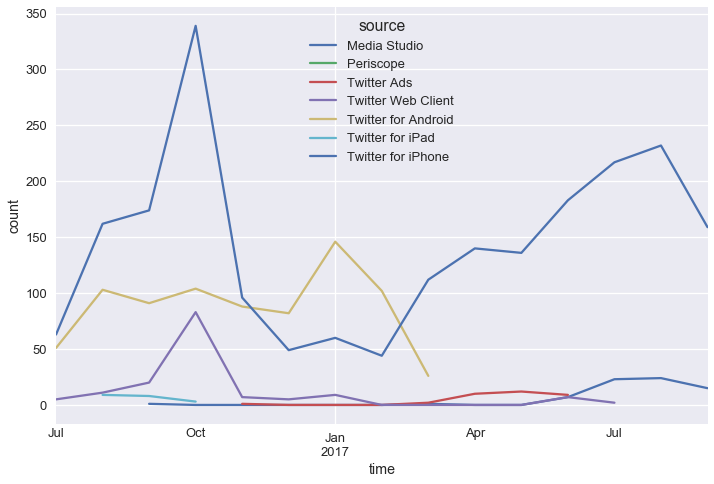

In [42]:
### make your plot here 
(trump.loc[:, ['est_time', 'source']]
 .set_index('est_time')
 .groupby('source')
 .resample('M')
 .size()
 .unstack(level=0)
 .plot()
)
plt.xlabel('time')
plt.ylabel('count')

According to the plot, Trump's tweets come from many different sources. It turns out that many of his tweets were not from Trump himself but from his staff. [Take a look at this Verge article.](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android)

Does the data support the information in the article? What else do you find out about changes in Trump's tweets sources from the plot?

In [43]:
q4d_answer = r"""

There does appear to be strong support for part of the article based upon this data. The tweets from Android have 
entirely disappeared which does seem to imply that Trump has stopped using an Android sometime around March when
this article was written. While there is a distinct increase in iPhone tweets this isn't necessarily proof
that those tweets are all coming from Trump. There had always been tweets coming from iPhones, even before Trump
had one so it is still likely that some of those iPhone tweets are coming from others besides Trump.

We also learn that there have been some other weird sources for Trump tweets including ipads, ads, a web client, etc.
that seem to imply some sort of social media manager was posting for Trump. This is not a super shocking revelation.
I don't see how it could be possible that the president or campaigner themselves has the time and energy to personally
handle all of their social media.

"""

display(Markdown(q4d_answer))



There does appear to be strong support for part of the article based upon this data. The tweets from Android have 
entirely disappeared which does seem to imply that Trump has stopped using an Android sometime around March when
this article was written. While there is a distinct increase in iPhone tweets this isn't necessarily proof
that those tweets are all coming from Trump. There had always been tweets coming from iPhones, even before Trump
had one so it is still likely that some of those iPhone tweets are coming from others besides Trump.

We also learn that there have been some other weird sources for Trump tweets including ipads, ads, a web client, etc.
that seem to imply some sort of social media manager was posting for Trump. This is not a super shocking revelation.
I don't see how it could be possible that the president or campaigner themselves has the time and energy to personally
handle all of their social media.



What are some ways we can distinguish between tweets that came from Trump and tweets from his staff? Before, it was as easy as checked which device the tweet came from. Now, we have to rely on more sophisticated methods.

## Project Checkpoint Reached

Congrats, you just reached the Project 1 checkpoint!

Now, run the cell below to submit your assignment to OkPy. The autograder should email you shortly with your autograded score. The autograder will only run once every 30 minutes.

Note that you'll probably get 0 points on Questions 5-8. Since you haven't gotten there yet, don't worry about missing those points.

**Note that the checkpoint is graded on completeness. This means that we'll check whether you attempted to solve each question, not whether you've gotten them right. When you submit the final submission of the project, you can go back and revise your answers to Questions 1-4.**

In [44]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: mattholtzer9@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/2kZKkJ
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



---
<br></br>

## Question 5: Sentiment Analysis

It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [45]:
!head vader_lexicon.txt

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]


---
<br/><br/>

## Question 5a

As you can see, the lexicon contains emojis too! The first column of the lexicon is the *token*, or the word itself. The second column is the *polarity* of the word, or how positive / negative it is.

(How did they decide the polarities of these words? What are the other two columns in the lexicon? See the link above.)

 Read in the lexicon into a DataFrame called `sent`. The index of the DF should be the tokens in the lexicon. `sent` should have one column: `polarity`: The polarity of each token.

In [46]:
with open("vader_lexicon.txt", "r") as f:
    text = f.read()

In [47]:
lex = text.split("\n")
lex

['$:\t-1.5\t0.80623\t[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]',
 '%)\t-0.4\t1.0198\t[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]',
 '%-)\t-1.5\t1.43178\t[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]',
 '&-:\t-0.4\t1.42829\t[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]',
 '&:\t-0.7\t0.64031\t[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]',
 "( '}{' )\t1.6\t0.66332\t[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]",
 '(%\t-0.9\t0.9434\t[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]',
 "('-:\t2.2\t1.16619\t[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]",
 "(':\t2.3\t0.9\t[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]",
 '((-:\t2.1\t0.53852\t[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]',
 '(*\t1.1\t1.13578\t[2, 1, 1, -1, 1, 2, 2, -1, 2, 2]',
 '(-%\t-0.7\t1.26886\t[-1, 2, 0, -1, -1, -2, 0, 0, -3, -1]',
 '(-*\t1.3\t1.26886\t[4, 1, 2, 0, 2, -1, 1, 2, 1, 1]',
 '(-:\t1.6\t0.8\t[2, 2, 1, 3, 1, 1, 1, 3, 1, 1]',
 '(-:0\t2.8\t0.87178\t[3, 2, 3, 4, 3, 2, 3, 1, 4, 3]',
 '(-:<\t-0.4\t2.15407\t[-3, 3, -1, -1, 2, -1, -2, 3, -3, -1]',
 '(-:o\t1.5\t0.67082\t[3, 1, 1, 2, 2, 2, 1, 1, 1, 1]',
 '(-:O\t1.5\t0.6708

In [48]:
def extract_parts(line):
    parts = line.split('\t')
    token = parts[0]
    polarity = parts[1]
    return [token,polarity]

In [49]:
[extract_parts(line)[1] for line in lex]

['-1.5',
 '-0.4',
 '-1.5',
 '-0.4',
 '-0.7',
 '1.6',
 '-0.9',
 '2.2',
 '2.3',
 '2.1',
 '1.1',
 '-0.7',
 '1.3',
 '1.6',
 '2.8',
 '-0.4',
 '1.5',
 '1.5',
 '-0.1',
 '1.9',
 '1.3',
 '2.1',
 '2.6',
 '2.2',
 '2.4',
 '-0.2',
 '2.5',
 '2.5',
 '1.1',
 '0.3',
 '2.2',
 '2.1',
 '1.5',
 '1.5',
 '2.0',
 '1.9',
 '1.6',
 '-2.0',
 '-2.1',
 '-2.1',
 '-2.2',
 '-2.1',
 '-1.8',
 '-1.9',
 '-2.3',
 '-2.6',
 '0.6',
 '0.3',
 '2.1',
 '2.4',
 '1.9',
 '1.6',
 '2.3',
 '1.6',
 '1.2',
 '2.3',
 '2.2',
 '-1.2',
 '-1.7',
 '-1.9',
 '-1.3',
 '-1.3',
 '-1.4',
 '-0.9',
 '-1.0',
 '-1.4',
 '0.1',
 '-1.2',
 '1.9',
 '1.4',
 '1.5',
 '1.9',
 '1.6',
 '-0.3',
 '2.1',
 '2.1',
 '3.2',
 '2.6',
 '2.4',
 '-2.9',
 '-3.1',
 '2.8',
 '-0.1',
 '2.1',
 '-2.2',
 '0.5',
 '-2.3',
 '-1.4',
 '-2.2',
 '-3.1',
 '1.5',
 '1.9',
 '1.7',
 '-0.3',
 '-1.6',
 '2.9',
 '-2.4',
 '-0.2',
 '-0.6',
 '-2.2',
 '2.3',
 '-2.4',
 '2.7',
 '-1.9',
 '2.0',
 '2.5',
 '-2.5',
 '-0.5',
 '-1.5',
 '1.3',
 '2.8',
 '1.7',
 '1.1',
 '-0.9',
 '-1.2',
 '-1.5',
 '2.3',
 '2.3',
 '0.

In [50]:
sent = pd.DataFrame(
    data = {
        'polarity' : [float(extract_parts(line)[1]) for line in lex]
    },
    index = [extract_parts(line)[0] for line in lex]
)

In [51]:
_ = ok.grade('q05a')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: mattholtzer9@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/318L1r
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



---
<br/><br/>

## Question 5b

Now, let's use this lexicon to calculate the overall sentiment for each of Trump's tweets. Here's the basic idea:

1. For each tweet, find the sentiment of each word.
2. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

First, let's lowercase the text in the tweets since the lexicon is also lowercase. Set the `text` column of the `trump` DF to be the lowercased text of each tweet.

In [52]:
trump.head()

retweet_count              source  \
910993665568526337           8467  Twitter for iPhone   
910992971620864004           4533  Twitter for iPhone   
910926223684931585          13297        Media Studio   
910898047931912192           7126        Media Studio   
910885755320459264           4954  Twitter for iPhone   

                                                                 text  \
910993665568526337      A big day for the U.S. at the United Nations!   
910992971620864004  Senator Luther Strange has gone up a lot in th...   
910926223684931585  Today, I announced a new Executive Order with ...   
910898047931912192  It was a great privilege to meet with Presiden...   
910885755320459264  It was wonderful to have President Petro Poros...   

                                  time                  est_time  hour  month  
910993665568526337 2017-09-21 22:26:29 2017-09-21 18:26:29-04:00    18      9  
910992971620864004 2017-09-21 22:23:44 2017-09-21 18:23:44-04:00    18      9  
910926223684931585 2017-09-21 17:58:30 2017-09-21 13:58:30-04:00    13      9  
910898047931912192 2017-09-21 16:06:32 2017-09-21 12:06:32-04:00    12      9  
910885755320459264 2017-09-21 15:17:42 2017-09-21 11:17:42-04:00    11      9

In [53]:
trump['text'] = [text.lower() for text in trump['text']]

In [54]:
_ = ok.grade('q05b')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: mattholtzer9@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/5yZNyx
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



---
<br/><br/>

## Question 5c

Now, let's get rid of punctuation since it'll cause us to fail to match words. Create a new column called `no_punc` in the `trump` DF to be the lowercased text of each tweet with all punctuation replaced by a single space. We consider punctuation characters to be any character that isn't a Unicode word character or a whitespace character. You may want to consult the Python documentation on regexes for this problem.

(Why don't we simply remove punctuation instead of replacing with a space? See if you can figure this out by looking at the tweet data.)

In [55]:
# Save your regex in punct_re
punct_re = r'[^\w\s]'
trump['no_punc'] = [re.sub(punct_re, ' ', text) for text in trump['text']]

In [56]:
trump.head()

retweet_count              source  \
910993665568526337           8467  Twitter for iPhone   
910992971620864004           4533  Twitter for iPhone   
910926223684931585          13297        Media Studio   
910898047931912192           7126        Media Studio   
910885755320459264           4954  Twitter for iPhone   

                                                                 text  \
910993665568526337      a big day for the u.s. at the united nations!   
910992971620864004  senator luther strange has gone up a lot in th...   
910926223684931585  today, i announced a new executive order with ...   
910898047931912192  it was a great privilege to meet with presiden...   
910885755320459264  it was wonderful to have president petro poros...   

                                  time                  est_time  hour  month  \
910993665568526337 2017-09-21 22:26:29 2017-09-21 18:26:29-04:00    18      9   
910992971620864004 2017-09-21 22:23:44 2017-09-21 18:23:44-04:00    18      9   
910926223684931585 2017-09-21 17:58:30 2017-09-21 13:58:30-04:00    13      9   
910898047931912192 2017-09-21 16:06:32 2017-09-21 12:06:32-04:00    12      9   
910885755320459264 2017-09-21 15:17:42 2017-09-21 11:17:42-04:00    11      9   

                                                              no_punc  
910993665568526337      a big day for the u s  at the united nations   
910992971620864004  senator luther strange has gone up a lot in th...  
910926223684931585  today  i announced a new executive order with ...  
910898047931912192  it was a great privilege to meet with presiden...  
910885755320459264  it was wonderful to have president petro poros...

In [57]:
_ = ok.grade('q05c')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: mattholtzer9@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/681O87
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



---
<br/> <br/>

## Question 5d:


Now, let's convert the tweets into what's called a *tidy format* to make the sentiments easier to calculate. Use the `no_punc` column of `trump` to create a table called `tidy_format`. The index of the table should be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

The first few rows of our `tidy_format` table look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>num</th>
      <th>word</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>907698529606541312</th>
      <td>0</td>
      <td>it</td>
    </tr>
    <tr>
      <th>907698529606541312</th>
      <td>1</td>
      <td>was</td>
    </tr>
    <tr>
      <th>907698529606541312</th>
      <td>2</td>
      <td>a</td>
    </tr>
    <tr>
      <th>907698529606541312</th>
      <td>3</td>
      <td>great</td>
    </tr>
    <tr>
      <th>907698529606541312</th>
      <td>4</td>
      <td>honor</td>
    </tr>
  </tbody>
</table>

**Note that you'll get different results depending on when you pulled in the tweets.** However, you can double check that your tweet with ID `907698529606541312` has the same rows as ours. Our tests don't check whether your table looks exactly like ours.

This will require some rather advanced Pandas hacking, but our solution uses a chain of 5 methods on the `trump` DF.

* **Hint 1:** Try looking at the `expand` argument to pandas' `str.split`.

* **Hint 2:** Try looking at the `stack()` method.


In [58]:
trump['no_punc'].str.split(expand = True).stack().reset_index()['level_0'].values

array(['910993665568526337', '910993665568526337', '910993665568526337',
       ..., '757618048664829952', '757618048664829952',
       '757618048664829952'], dtype=object)

In [59]:
tidy_format = pd.DataFrame(
    data = {
        'num': trump['no_punc'].str.split(expand = True).stack().reset_index()['level_1'].values,
        'word': trump['no_punc'].str.split(expand = True).stack().reset_index()[0].values
    },
    index = trump['no_punc'].str.split(expand = True).stack().reset_index()['level_0'].values
)
tidy_format.head()

num word
910993665568526337    0    a
910993665568526337    1  big
910993665568526337    2  day
910993665568526337    3  for
910993665568526337    4  the

In [60]:
_ = ok.grade('q05d')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: mattholtzer9@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/73ZP3w
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



---
<br/> <br/>


## Question 5e:

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table. Calculate a table called `polarities`. Its index should be the IDs of the tweets (one row per ID). It should have one column called `polarity` containing the summed sentiment polarity of each tweet.

Here are the first couple rows of our table. Again, you may have different tweet IDs depending on when you downloaded the tweets, but make sure the format looks the same.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>polarity</th>
    </tr>
    <tr>
      <th>index</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>755486029742641152</th>
      <td>0.0</td>
    </tr>
    <tr>
      <th>755502053003190273</th>
      <td>0.0</td>
    </tr>
    <tr>
      <th>755525857456844800</th>
      <td>2.2</td>
    </tr>
    <tr>
      <th>755551039244341253</th>
      <td>6.7</td>
    </tr>
    <tr>
      <th>755708398537154560</th>
      <td>7.6</td>
    </tr>
  </tbody>
</table>

In [61]:
sent.head()

polarity
$:       -1.5
%)       -0.4
%-)      -1.5
&-:      -0.4
&:       -0.7

In [62]:
joined = tidy_format.join(sent, on = 'word')
joined.head()

num word  polarity
910993665568526337    0    a       NaN
910993665568526337    1  big       NaN
910993665568526337    2  day       NaN
910993665568526337    3  for       NaN
910993665568526337    4  the       NaN

In [63]:
joins = joined.groupby(joined.index).sum().fillna(0)
joins.head()

num  polarity
757618048664829952   36       0.0
757650904896139264  105       5.0
757687988189065216  120       1.5
757688331597668353   66       1.5
757690132111777792  136      -4.3

In [64]:
polarities = pd.DataFrame(data = {'polarity': joins['polarity']}, index = joins.index)
polarities.head()

polarity
757618048664829952       0.0
757650904896139264       5.0
757687988189065216       1.5
757688331597668353       1.5
757690132111777792      -4.3

In [65]:
_ = ok.grade('q05e')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: mattholtzer9@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/9rZ0rP
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



---
<br/> <br/>


## Question 5f:

Finally, use the `polarities` and `trump` tables to create a new table called `senti` that is the `trump` table with an extra column called `polarity` containing the sentiment polarity of each tweet.

In [66]:
trump.join(polarities).head()

retweet_count              source  \
910993665568526337           8467  Twitter for iPhone   
910992971620864004           4533  Twitter for iPhone   
910926223684931585          13297        Media Studio   
910898047931912192           7126        Media Studio   
910885755320459264           4954  Twitter for iPhone   

                                                                 text  \
910993665568526337      a big day for the u.s. at the united nations!   
910992971620864004  senator luther strange has gone up a lot in th...   
910926223684931585  today, i announced a new executive order with ...   
910898047931912192  it was a great privilege to meet with presiden...   
910885755320459264  it was wonderful to have president petro poros...   

                                  time                  est_time  hour  month  \
910993665568526337 2017-09-21 22:26:29 2017-09-21 18:26:29-04:00    18      9   
910992971620864004 2017-09-21 22:23:44 2017-09-21 18:23:44-04:00    18      9   
910926223684931585 2017-09-21 17:58:30 2017-09-21 13:58:30-04:00    13      9   
910898047931912192 2017-09-21 16:06:32 2017-09-21 12:06:32-04:00    12      9   
910885755320459264 2017-09-21 15:17:42 2017-09-21 11:17:42-04:00    11      9   

                                                              no_punc  \
910993665568526337      a big day for the u s  at the united nations    
910992971620864004  senator luther strange has gone up a lot in th...   
910926223684931585  today  i announced a new executive order with ...   
910898047931912192  it was a great privilege to meet with presiden...   
910885755320459264  it was wonderful to have president petro poros...   

                    polarity  
910993665568526337       1.8  
910992971620864004       3.3  
910926223684931585       1.6  
910898047931912192       4.6  
910885755320459264       2.7

In [67]:
senti = trump.join(polarities)

In [68]:
_ = ok.grade('q05f')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: mattholtzer9@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/gJomJ9
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



Now we have a measure of the sentiment of each of his tweets! Note that this calculation is rather basic; you can read over the VADER readme to understand a more robust sentiment analysis.

Now, run the cells below to see the most positive and most negative tweets from Trump in your dataset:

In [69]:
print('Most negative tweets:')
for t in senti.sort_values('polarity').head()['text']:
    print('  ', t)

Most negative tweets:
   "@fiiibuster: @jeffzeleny pathetic - you have no sufficient evidence that donald trump did not suffer from voter fraud, shame! bad reporter.
   democrat jon ossoff would be a disaster in congress. very weak on crime and illegal immigration, bad for jobs and wants higher taxes. say no
   rt @seanspicer: .@timkaine wants to tough on crime - fails to talk about defending rapists and murders #vpdebate
   the fake news media has never been so wrong or so dirty. purposely incorrect stories and phony sources to meet their agenda of hate. sad!
   the failing new york times foiled u.s. attempt to kill the single most wanted terrorist,al-baghdadi.their sick agenda over national security


In [70]:
print('Most positive tweets:')
for t in senti.sort_values('polarity', ascending=False).head()['text']:
    print('  ', t)

Most positive tweets:
   thank you to linda bean of l.l.bean for your great support and courage. people will support you even more now. buy l.l.bean. @lbperfectmaine
   rt @ivankatrump: 2016 has been one of the most eventful and exciting years of my life. i wish you peace, joy, love and laughter. happy new…
   "@pauladuvall2: we're all enjoying you, as well, mr. t.! you've inspired hope and a positive spirit throughout america! god bless you!" nice
   great honor to be endorsed by popular &amp; successful @gov_gilmore of va. a state that i very much want to win-thx jim! https://t.co/x4y1tafhvn
   hope you like my nomination of judge neil gorsuch for the united states supreme court. he is a good and brilliant man, respected by all.


---
<br></br>

## Question 5g

Use seaborn to create a `distplot` of the sentiments. What do you notice? (You don't have to write this down in the notebook.)

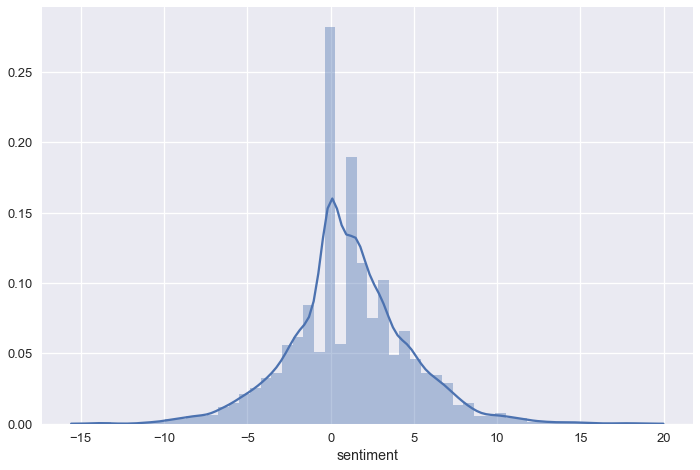

In [71]:
### make your plot here
sns.distplot(senti['polarity'], axlabel = 'sentiment')

---
<br></br>

## Question 5h
Create a line plot of the sentiment of Trump's tweets over time. Plot the mean sentiment of two weeks' of his tweets over time. Then, plot vertical lines corresponding to his election and inauguration dates. Your final plot should look like:

![](senti_time.png)

Then, describe what you notice and save your result in the variable `senti_time_answer`.

In [72]:
senti.head()

retweet_count              source  \
910993665568526337           8467  Twitter for iPhone   
910992971620864004           4533  Twitter for iPhone   
910926223684931585          13297        Media Studio   
910898047931912192           7126        Media Studio   
910885755320459264           4954  Twitter for iPhone   

                                                                 text  \
910993665568526337      a big day for the u.s. at the united nations!   
910992971620864004  senator luther strange has gone up a lot in th...   
910926223684931585  today, i announced a new executive order with ...   
910898047931912192  it was a great privilege to meet with presiden...   
910885755320459264  it was wonderful to have president petro poros...   

                                  time                  est_time  hour  month  \
910993665568526337 2017-09-21 22:26:29 2017-09-21 18:26:29-04:00    18      9   
910992971620864004 2017-09-21 22:23:44 2017-09-21 18:23:44-04:00    18      9   
910926223684931585 2017-09-21 17:58:30 2017-09-21 13:58:30-04:00    13      9   
910898047931912192 2017-09-21 16:06:32 2017-09-21 12:06:32-04:00    12      9   
910885755320459264 2017-09-21 15:17:42 2017-09-21 11:17:42-04:00    11      9   

                                                              no_punc  \
910993665568526337      a big day for the u s  at the united nations    
910992971620864004  senator luther strange has gone up a lot in th...   
910926223684931585  today  i announced a new executive order with ...   
910898047931912192  it was a great privilege to meet with presiden...   
910885755320459264  it was wonderful to have president petro poros...   

                    polarity  
910993665568526337       1.8  
910992971620864004       3.3  
910926223684931585       1.6  
910898047931912192       4.6  
910885755320459264       2.7



Trump's tweets went extremely upward in positivity in the time leading up to his election after a sharp decrease
in the weeks before than then decreased drastically again up through his inaguaration when they bounce back again.
I'm an econ major, not a political science major, but I'll go out on a limb and suggest that as a strategy he went
negative in the month or two before to get people angry, then went positive to get people convinced he can win and
actually show up to the polls then got more negative once he won so that he could convince the public that things
were not good so that he could make many changes with public approval once he got into office.



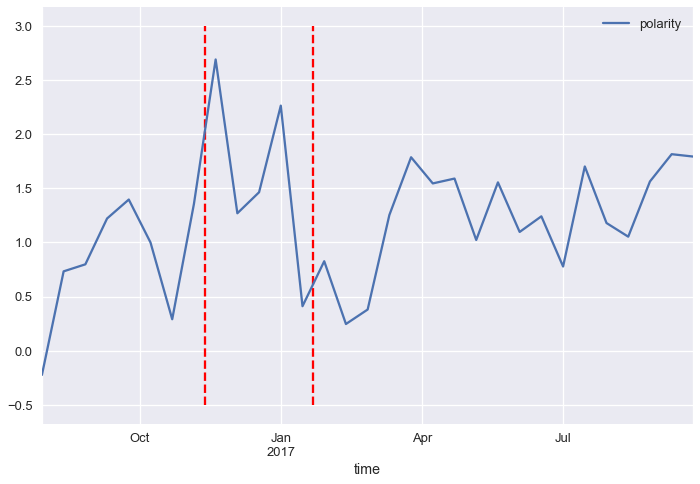

In [73]:
# Create your plot here...

ax = (senti.loc[:, ['time', 'polarity']]
 .set_index('time')
 .resample('2W')
 .mean()
 .plot()
)
ax.vlines([pd.to_datetime('11/08/2016'),pd.to_datetime('01/20/2017')], -.5, 3, linestyles = 'dashed', colors = 'R')
plt.xlabel('time')

# ...then write your takeaways here.
senti_time_answer = '''

Trump's tweets went extremely upward in positivity in the time leading up to his election after a sharp decrease
in the weeks before than then decreased drastically again up through his inaguaration when they bounce back again.
I'm an econ major, not a political science major, but I'll go out on a limb and suggest that as a strategy he went
negative in the month or two before to get people angry, then went positive to get people convinced he can win and
actually show up to the polls then got more negative once he won so that he could convince the public that things
were not good so that he could make many changes with public approval once he got into office.

'''
display(Markdown(senti_time_answer))

## Question 6: Hashtags

Let's return now to the problem of determining which tweets were from Trump and which were from his aides. As a reminder, most analysts agree that tweets that came from an Android device were likely from Trump himself, not one of his aides ([example](http://didtrumptweetit.com/machine-learning-tweet-prediction/)).

In addition, browsing his Twitter shows that some tweets that sound more "official" often have a hashtag, link, or a picture:

![](aide.png)

Whereas tweets that sound like Trump himself usually don't have a hashtag, link, or picture:

![](trump.png)

So, we can hypothesize that if a tweet has a hashtag, link, or picture it came from one of Trump's aides, not Trump himself. Let's see if this idea is backed up by the data.

---
<br></br>

## Question 6a

Create a DF called `hash_or_link` that contains only the rows from the `senti` table where the tweet isn't a retweet and contains a hashtag, link, or picture. We say that:

- A tweet is a retweet if it has the string 'rt' anywhere in the tweet if it is preceeded and followed by a non-word character (the start and end of the string count as non-word characters).
- A tweet has a hashtag if it has the character '#' anywhere in the tweet followed by a letter.
- A tweet contains a link or a picture if it has the word `http` anywhere in the tweet

(You can check out Trump's Twitter for why these criteria are true).

In [74]:
senti.head()

retweet_count              source  \
910993665568526337           8467  Twitter for iPhone   
910992971620864004           4533  Twitter for iPhone   
910926223684931585          13297        Media Studio   
910898047931912192           7126        Media Studio   
910885755320459264           4954  Twitter for iPhone   

                                                                 text  \
910993665568526337      a big day for the u.s. at the united nations!   
910992971620864004  senator luther strange has gone up a lot in th...   
910926223684931585  today, i announced a new executive order with ...   
910898047931912192  it was a great privilege to meet with presiden...   
910885755320459264  it was wonderful to have president petro poros...   

                                  time                  est_time  hour  month  \
910993665568526337 2017-09-21 22:26:29 2017-09-21 18:26:29-04:00    18      9   
910992971620864004 2017-09-21 22:23:44 2017-09-21 18:23:44-04:00    18      9   
910926223684931585 2017-09-21 17:58:30 2017-09-21 13:58:30-04:00    13      9   
910898047931912192 2017-09-21 16:06:32 2017-09-21 12:06:32-04:00    12      9   
910885755320459264 2017-09-21 15:17:42 2017-09-21 11:17:42-04:00    11      9   

                                                              no_punc  \
910993665568526337      a big day for the u s  at the united nations    
910992971620864004  senator luther strange has gone up a lot in th...   
910926223684931585  today  i announced a new executive order with ...   
910898047931912192  it was a great privilege to meet with presiden...   
910885755320459264  it was wonderful to have president petro poros...   

                    polarity  
910993665568526337       1.8  
910992971620864004       3.3  
910926223684931585       1.6  
910898047931912192       4.6  
910885755320459264       2.7

In [75]:
# You must save your regex for retweets in this variable
rt_re = r'(^|\W+)rt(\W+|$)'
# You must save your regex for hashtags, links, or pictures in this variable
hash_re = r'(#(\w+))|http'
hash_or_link = senti.loc[(senti['text'].str.contains(rt_re)==False) & (senti['text'].str.contains(hash_re)==True)]
hash_or_link.head()

/Users/matt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


retweet_count              source  \
910926223684931585          13297        Media Studio   
910898047931912192           7126        Media Studio   
910885755320459264           4954  Twitter for iPhone   
910885156373721092           5274        Media Studio   
910703407555600386          10370  Twitter for iPhone   

                                                                 text  \
910926223684931585  today, i announced a new executive order with ...   
910898047931912192  it was a great privilege to meet with presiden...   
910885755320459264  it was wonderful to have president petro poros...   
910885156373721092  it was a pleasure to have president ashraf gha...   
910703407555600386  governor @ricardorossello- \nwe are with you a...   

                                  time                  est_time  hour  month  \
910926223684931585 2017-09-21 17:58:30 2017-09-21 13:58:30-04:00    13      9   
910898047931912192 2017-09-21 16:06:32 2017-09-21 12:06:32-04:00    12      9   
910885755320459264 2017-09-21 15:17:42 2017-09-21 11:17:42-04:00    11      9   
910885156373721092 2017-09-21 15:15:19 2017-09-21 11:15:19-04:00    11      9   
910703407555600386 2017-09-21 03:13:07 2017-09-20 23:13:07-04:00    23      9   

                                                              no_punc  \
910926223684931585  today  i announced a new executive order with ...   
910898047931912192  it was a great privilege to meet with presiden...   
910885755320459264  it was wonderful to have president petro poros...   
910885156373721092  it was a pleasure to have president ashraf gha...   
910703407555600386  governor  ricardorossello  \nwe are with you a...   

                    polarity  
910926223684931585       1.6  
910898047931912192       4.6  
910885755320459264       2.7  
910885156373721092       2.7  
910703407555600386       1.9

In [76]:
len(hash_or_link)

1335

In [77]:
_ = ok.grade('q06a')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: mattholtzer9@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/mZxvZp
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



--- 
<br></br>

## Question 6b

Create a line plot of the number of tweets containing a hashtag, link, or picture from each tweet device.

If a device doesn't have at least 20 tweets in a particular year, don't include the tweets from that device for that year. (Eg. if there are 100 tweets from Twitter Ads in 2016 but only 10 in 2017, plot the counts for Twitter Ads in 2016 but not 2017.)

Aggregate the counts for each two week period. Your final plot should look like:

![](hashtag_by_device.png)

*Hint:* If you can get a table in the following format, you can just call `.plot()` on it to generate the plot.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>source</th>
      <th>Media Studio</th>
      <th>Twitter Ads</th>
      <th>Twitter Web Client</th>
      <th>Twitter for Android</th>
      <th>Twitter for iPhone</th>
    </tr>
    <tr>
      <th>time</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2016-07-24</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>4.0</td>
      <td>10.0</td>
      <td>14.0</td>
    </tr>
    <tr>
      <th>2016-08-07</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>5.0</td>
      <td>15.0</td>
      <td>91.0</td>
    </tr>
    <tr>
      <th>2016-08-21</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>9.0</td>
      <td>10.0</td>
      <td>44.0</td>
    </tr>
    <tr>
      <th>2016-09-04</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>0.0</td>
      <td>20.0</td>
      <td>51.0</td>
    </tr>
    <tr>
      <th>2016-09-18</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>1.0</td>
      <td>12.0</td>
      <td>59.0</td>
    </tr>
  </tbody>
</table>

What conclusions can you draw from this plot? Does this plot allow us to say whether a tweet containing a hashtag/link/picture likely came from Trump himself? Write your takeaways in `hashtag_answer` variable.

In [78]:
hash_or_link['year'] = hash_or_link['est_time'].dt.year

/Users/matt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [79]:
temp_hash = hash_or_link[hash_or_link.groupby(['source', 'year']).source.transform(len) >20]
temp_hash.head()

retweet_count              source  \
910926223684931585          13297        Media Studio   
910898047931912192           7126        Media Studio   
910885755320459264           4954  Twitter for iPhone   
910885156373721092           5274        Media Studio   
910703407555600386          10370  Twitter for iPhone   

                                                                 text  \
910926223684931585  today, i announced a new executive order with ...   
910898047931912192  it was a great privilege to meet with presiden...   
910885755320459264  it was wonderful to have president petro poros...   
910885156373721092  it was a pleasure to have president ashraf gha...   
910703407555600386  governor @ricardorossello- \nwe are with you a...   

                                  time                  est_time  hour  month  \
910926223684931585 2017-09-21 17:58:30 2017-09-21 13:58:30-04:00    13      9   
910898047931912192 2017-09-21 16:06:32 2017-09-21 12:06:32-04:00    12      9   
910885755320459264 2017-09-21 15:17:42 2017-09-21 11:17:42-04:00    11      9   
910885156373721092 2017-09-21 15:15:19 2017-09-21 11:15:19-04:00    11      9   
910703407555600386 2017-09-21 03:13:07 2017-09-20 23:13:07-04:00    23      9   

                                                              no_punc  \
910926223684931585  today  i announced a new executive order with ...   
910898047931912192  it was a great privilege to meet with presiden...   
910885755320459264  it was wonderful to have president petro poros...   
910885156373721092  it was a pleasure to have president ashraf gha...   
910703407555600386  governor  ricardorossello  \nwe are with you a...   

                    polarity  year  
910926223684931585       1.6  2017  
910898047931912192       4.6  2017  
910885755320459264       2.7  2017  
910885156373721092       2.7  2017  
910703407555600386       1.9  2017

In [80]:
(temp_hash.loc[:, ['est_time', 'source']]
 .set_index('est_time')
 .groupby('source')
 .resample('M')
 .size()
 .unstack(level=0)
)

source                     Media Studio  Twitter Ads  Twitter Web Client  \
est_time                                                                   
2016-07-31 00:00:00-04:00           NaN          NaN                 3.0   
2016-08-31 00:00:00-04:00           NaN          NaN                 8.0   
2016-09-30 00:00:00-04:00           NaN          NaN                 7.0   
2016-10-31 00:00:00-04:00           NaN          NaN                60.0   
2016-11-30 00:00:00-05:00           NaN          NaN                 3.0   
2016-12-31 00:00:00-05:00           NaN          NaN                 1.0   
2017-01-31 00:00:00-05:00           NaN          NaN                 NaN   
2017-02-28 00:00:00-05:00           NaN          NaN                 NaN   
2017-03-31 00:00:00-04:00           1.0          2.0                 NaN   
2017-04-30 00:00:00-04:00           0.0         10.0                 NaN   
2017-05-31 00:00:00-04:00           0.0         12.0                 NaN   
2017-06-30 00:00:00-04:00           7.0          9.0                 NaN   
2017-07-31 00:00:00-04:00          23.0          NaN                 NaN   
2017-08-31 00:00:00-04:00          24.0          NaN                 NaN   
2017-09-30 00:00:00-04:00          15.0          NaN                 NaN   

source                     Twitter for Android  Twitter for iPhone  
est_time                                                            
2016-07-31 00:00:00-04:00                  7.0                37.0  
2016-08-31 00:00:00-04:00                 18.0               117.0  
2016-09-30 00:00:00-04:00                  7.0               127.0  
2016-10-31 00:00:00-04:00                 16.0               272.0  
2016-11-30 00:00:00-05:00                  4.0                75.0  
2016-12-31 00:00:00-05:00                  2.0                32.0  
2017-01-31 00:00:00-05:00                  NaN                43.0  
2017-02-28 00:00:00-05:00                  NaN                39.0  
2017-03-31 00:00:00-04:00                  NaN                49.0  
2017-04-30 00:00:00-04:00                  NaN                34.0  
2017-05-31 00:00:00-04:00                  NaN                42.0  
2017-06-30 00:00:00-04:00                  NaN                41.0  
2017-07-31 00:00:00-04:00                  NaN                58.0  
2017-08-31 00:00:00-04:00                  NaN                49.0  
2017-09-30 00:00:00-04:00                  NaN                47.0



It is clear that the largest amount of hashtags come from tweets sent on iphone, and that number proceeds to decrease
drastically around the time he was elected, with the peak at election. Since we've already discussed that tweets with 
hashtags and links are more likely to have come from somebody besides him, this seems to suggest that after his
election, Trump has taken more control of his twitter and the peak of professionals using his twitter was during
the last couple weeks of his campaign.



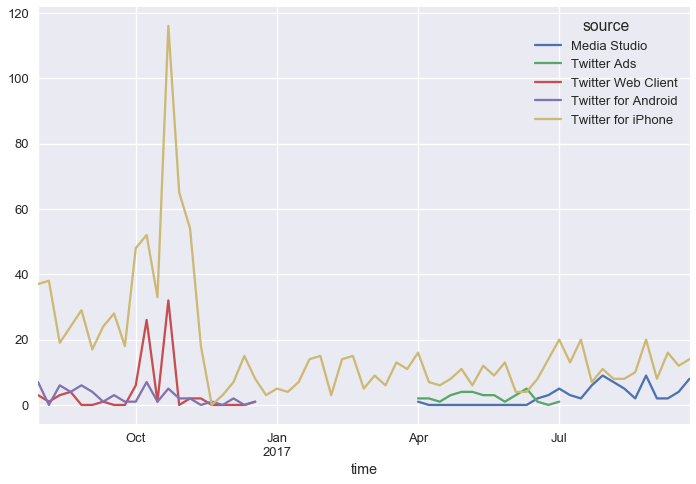

In [81]:
# Create your plot here...

(temp_hash.loc[:, ['est_time', 'source']]
 .set_index('est_time')
 .groupby('source')
 .resample('W')
 .size()
 .unstack(level=0)
 .plot()
)
plt.xlabel('time')

# ...then write your takeaways here.
hashtag_answer = '''

It is clear that the largest amount of hashtags come from tweets sent on iphone, and that number proceeds to decrease
drastically around the time he was elected, with the peak at election. Since we've already discussed that tweets with 
hashtags and links are more likely to have come from somebody besides him, this seems to suggest that after his
election, Trump has taken more control of his twitter and the peak of professionals using his twitter was during
the last couple weeks of his campaign.

'''
display(Markdown(hashtag_answer))

--- 
<br></br>

## Question 6c 

Now, let's see whether there's a difference in sentiment for tweets with hashtags and those without.

Create a line plot of the sentiment of Trump's non-retweet tweets over time, taking the mean sentiment for every two week period. Plot one line for tweets with hashtags and one for tweets without. Then, draw two vertical lines for the election date and inauguration date. Draw a horizontal line for y=0. Your plot should look like:

![](hash_senti.png)

What do you notice about the plot? What conclusions can you draw? Write your answers in `hash_senti_answer`.

Hint 1: You'll want to start use your `senti` table, not your `hash_or_link` table. Try adding a column to `senti` containing True if the tweet has a hashtag/link/picture.

Hint 2: You shouldn't use your `no_punc` column. Think about why not.

In [82]:
senti_no_rt = senti.loc[senti['text'].str.contains(rt_re)==False]
len(senti_no_rt)

/Users/matt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


2914

In [83]:
senti_no_rt['has_hash_or_link'] = senti_no_rt['text'].str.contains(hash_re)
len(senti_no_rt.loc[senti_no_rt['has_hash_or_link']==True])

/Users/matt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.
/Users/matt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


1335

In [108]:
ay = (senti_no_rt.loc[:, ['time', 'polarity', 'has_hash_or_link']]
 .set_index('time')
 .groupby('has_hash_or_link')
 .resample('2W')
 .mean()
 .unstack(level = 0)
 .polarity
)
ay

has_hash_or_link     False     True 
time                                
2016-07-31       -0.872059  0.642553
2016-08-14        0.189063  1.140299
2016-08-28        0.606383  0.938571
2016-09-11        0.616129  1.815686
2016-09-25        0.114000  2.524074
2016-10-09        1.521538  0.938532
2016-10-23       -0.122414  0.397248
2016-11-06        0.580645  1.581250
2016-11-20        2.628205  2.883333
2016-12-04        1.037705  2.223077
2016-12-18        1.180000  2.076000
2017-01-01        1.702703  2.612500
2017-01-15        0.090698  2.160000
2017-01-29        0.439655  1.440625
2017-02-12       -0.222222  2.138889
2017-02-26        0.009302  1.180000
2017-03-12        0.942857  2.086667
2017-03-26        1.089655  3.100000
2017-04-09        0.554286  2.785185
2017-04-23        0.902273  4.015789
2017-05-07        0.678431  2.128000
2017-05-21        0.568966  2.740741
2017-06-04        0.873684  1.528571
2017-06-18        0.704348  2.384000
2017-07-02        0.043333  1.911364
2017-07-16        1.256140  3.100000
2017-07-30        0.438961  2.917647
2017-08-13        0.863830  2.617857
2017-08-27        1.142857  2.329268
2017-09-10        1.511429  2.475000
2017-09-24        1.568889  2.694737



Given that tweets with hashtags and links are significantly more likely not to come from Trump and those tweets tend
to be substantially more positive, it is likely that tweets coming from Trump are more negative based upon this graph.
The time that Trump's twets have been the most in sync with those of his staff were right before his election, a time
when Trump himself may have been feeling more positive as his odds of winning seemed to increase by the day.



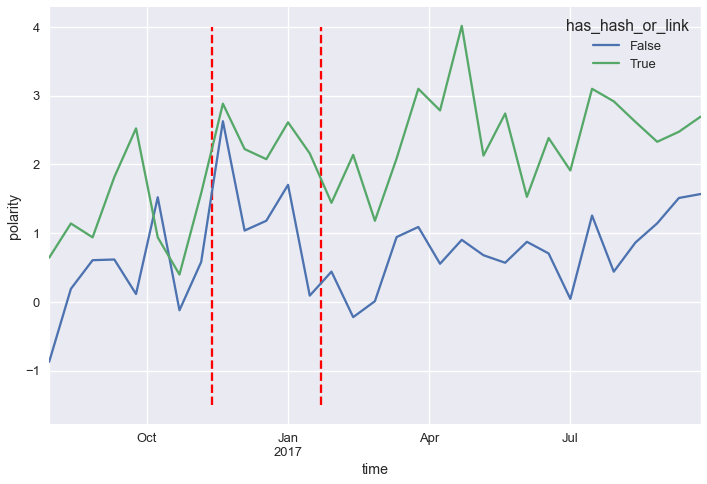

In [111]:
# Create your plot here...

ay = (senti_no_rt.loc[:, ['time', 'polarity', 'has_hash_or_link']]
 .set_index('time')
 .groupby('has_hash_or_link')
 .resample('2W')
 .mean()
 .unstack(level = 0)
 .polarity.plot()
)
ay.vlines([pd.to_datetime('11/08/2016'),pd.to_datetime('01/20/2017')], -1.5, 4, linestyles = 'dashed', colors = 'R')
plt.xlabel('time')
plt.ylabel('polarity')

# ...then write your takeaways here.
hash_senti_answer = '''

Given that tweets with hashtags and links are significantly more likely not to come from Trump and those tweets tend
to be substantially more positive, it is likely that tweets coming from Trump are more negative based upon this graph.
The time that Trump's twets have been the most in sync with those of his staff were right before his election, a time
when Trump himself may have been feeling more positive as his odds of winning seemed to increase by the day.

'''
display(Markdown(hash_senti_answer))

--- 

## Question 7: Engagement

---
<br></br>
## Question 7a

Which of Trump's tweets had the most retweets? Were there certain words that often led to more retweets?

We can find this out by using our `tidy_format` DataFrame. For each word in the `tidy_format` DF, find out the number of retweets that its tweet got. Filter out words that didn't appear in at least 25 tweets, find out the median number of retweets each word got, and save the top 20 most retweeted words into a DataFrame called `top_20`. Your `top_20` table should have this format:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>retweet_count</th>
    </tr>
    <tr>
      <th>word</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>fake</th>
      <td>22963.0</td>
    </tr>
    <tr>
      <th>news</th>
      <td>20463.0</td>
    </tr>
    <tr>
      <th>ds100</th>
      <td>20432.0</td>
    </tr>
    <tr>
      <th>great</th>
      <td>20159.0</td>
    </tr>
    <tr>
      <th>class</th>
      <td>20121.0</td>
    </tr>
  </tbody>
</table>

In [88]:
tidy_format.head()

num word
910993665568526337    0    a
910993665568526337    1  big
910993665568526337    2  day
910993665568526337    3  for
910993665568526337    4  the

In [89]:
temp_tidy = tidy_format[tidy_format.groupby('word').word.transform(len) > 25]
retweets_by_word = temp_tidy.join(senti['retweet_count']).groupby('word').median().drop('num', 1)
retweets_by_word.sort_values('retweet_count', ascending = False).head(30)

retweet_count
word                         
fake                  22984.0
news                  20537.5
russia                20444.0
korea                 20407.0
russian               20036.0
lost                  20036.0
story                 19994.5
terrible              19959.0
administration        19882.0
any                   19635.5
should                19573.0
ever                  19479.0
nothing               19353.5
china                 19205.0
totally               19172.0
before                19104.5
let                   19097.5
history               18763.0
security              18607.0
why                   18604.5
election              18576.5
illegal               18561.5
fbi                   18556.5
must                  18529.5
being                 18462.0
come                  18422.0
into                  18149.0
sad                   18087.0
give                  17982.0
media                 17888.0

In [90]:
top_20 = retweets_by_word.sort_values('retweet_count', ascending = False).head(20)

In [91]:
_ = ok.grade('q07a')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: mattholtzer9@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/Krq3Zz
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



Here's a bar chart of your results:

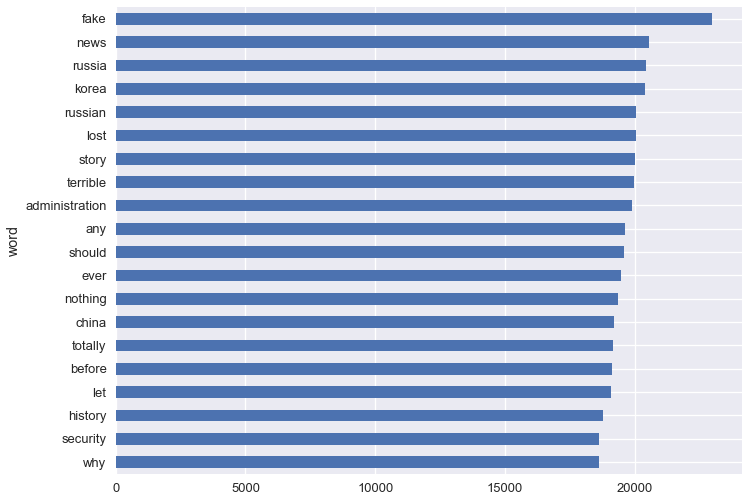

In [92]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8))

---
<br></br>

## Question 7b

The phrase "fake news" is apparently really popular! We can conclude that Trump's tweets containing "fake" and/or "news" result in the most retweets relative to words his other tweets. Or can we?

Consider each of the statements about possible confounding factors below. State whether each statement is true or false and explain. If the statement is true, state whether the confounding factor could have made "fake" and/or "news" higher on our list than they should be.

1. We didn't restrict our word list to nouns, so we have unhelpful words like "let" and "any" in our result.
1. We didn't remove hashtags in our text, so we have duplicate words (eg. #great and great).
1. We didn't account for the fact that Trump's follower count has increased over time.

In [93]:
engagement_answer = '''

1. True. This statement is true but it could not have made fake or news higher on the list than it should be.
Letting in more words can only work to bring fake/news down on the list since they are just more items for those 
words to compete with and don't affect the median retweet count of other words. Adding words from the sample has 
no effect on anything else in the table.

2. False. We did remove hashtags from our list since we used tidy_format as a starting place and tidy_format does not
contain any hashtags as we removed them way back in an earlier part of this assignment.

3. True. This is a serious factor to be considered. "Fake News" has not been a constant and is very connected to a specific
time. If it is true that these fake news tweets are more recent and his following and activity has increased with time
than there is a good case to be made that this could affect the retweets. A better way of running this table could
be to merge another dataset with trump follower counts at different times and look at ratios of followers to retweets
for each word instead.

'''
display(Markdown(engagement_answer))



1. True. This statement is true but it could not have made fake or news higher on the list than it should be.
Letting in more words can only work to bring fake/news down on the list since they are just more items for those 
words to compete with and don't affect the median retweet count of other words. Adding words from the sample has 
no effect on anything else in the table.

2. False. We did remove hashtags from our list since we used tidy_format as a starting place and tidy_format does not
contain any hashtags as we removed them way back in an earlier part of this assignment.

3. True. This is a serious factor to be considered. "Fake News" has not been a constant and is very connected to a specific
time. If it is true that these fake news tweets are more recent and his following and activity has increased with time
than there is a good case to be made that this could affect the retweets. A better way of running this table could
be to merge another dataset with trump follower counts at different times and look at ratios of followers to retweets
for each word instead.



---
## Question 8: Fake News

---
<br></br>
## Question 8a 

Let's investigate the term "fake news" a bit more. Create a table called `fake_counts` that has two columns:

1. `fake_news`: The number of tweets containing the term "fake news".
1. `total`: The total number of tweets for the time period.

The index of the table should be datetimes for each two-week period in the data.

The resulting table should look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fake_news</th>
      <th>total</th>
    </tr>
    <tr>
      <th>time</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2016-07-31</th>
      <td>0</td>
      <td>79</td>
    </tr>
    <tr>
      <th>2016-08-14</th>
      <td>0</td>
      <td>143</td>
    </tr>
    <tr>
      <th>2016-08-28</th>
      <td>0</td>
      <td>118</td>
    </tr>
    <tr>
      <th>2016-09-11</th>
      <td>0</td>
      <td>121</td>
    </tr>
    <tr>
      <th>2016-09-25</th>
      <td>0</td>
      <td>111</td>
    </tr>
  </tbody>
</table>

In [94]:
fakenews_re = r'fake news'
fakenews = senti.loc[(senti['text'].str.contains(fakenews_re)==True)]
notfakenews = senti.loc[(senti['text'].str.contains(fakenews_re)==False)]

In [95]:
senti['fake_news'] = senti['text'].str.contains(fakenews_re)
senti.loc[senti['fake_news']==True]

retweet_count               source  \
907588803161939968          24186   Twitter for iPhone   
901031532164468736          18529   Twitter for iPhone   
900706146943717377          14869   Twitter for iPhone   
900352052068401154          19688   Twitter for iPhone   
899625157421039616          20674   Twitter for iPhone   
899623926082535425          15988   Twitter for iPhone   
899411254061694979          28808   Twitter for iPhone   
898964640817983488          28272   Twitter for iPhone   
898130328916824064          33104   Twitter for iPhone   
897223558073602049          33960   Twitter for iPhone   
894984126582972416          25721   Twitter for iPhone   
894653195112378368          20295   Twitter for iPhone   
894518002795900928          17473   Twitter for iPhone   
894514535062790144          12006   Twitter for iPhone   
894512983384129536          19468   Twitter for iPhone   
894367017054208001          23042   Twitter for iPhone   
892920397162848257          32832   Twitter for iPhone   
892383242535481344          33736   Twitter for iPhone   
891437168798965761          18620   Twitter for iPhone   
890568797941362690          12438   Twitter for iPhone   
889675644396867584          17361   Twitter for iPhone   
889673743873843200          13280   Twitter for iPhone   
889435104841523201          32952   Twitter for iPhone   
888724194820857857          17411   Twitter for iPhone   
888575966259314691          22932   Twitter for iPhone   
887477071160762369          27306   Twitter for iPhone   
887475373981696000          26552   Twitter for iPhone   
886544734788997125          23872   Twitter for iPhone   
886534810575020032          38135   Twitter for iPhone   
884378624660582405          26411   Twitter for iPhone   
...                           ...                  ...   
839116941956640768          25786  Twitter for Android   
835916511944523777          24471  Twitter for Android   
835325771858251776          26117  Twitter for Android   
833681539997253636          34500  Twitter for Android   
832945737625387008          38852  Twitter for Android   
832708293516632065          52523  Twitter for Android   
832238070460186625          26900  Twitter for Android   
832230758299340800          19719  Twitter for Android   
831830548565852160          25627  Twitter for Android   
830904083519242241          25339  Twitter for Android   
830751875578355713          24749  Twitter for Android   
830047626414477312          23554  Twitter for Android   
829681034564341760          14811  Twitter for Android   
829357626798530561          18943   Twitter for iPhone   
828575949268606977          23824  Twitter for Android   
828574430800539648          36022  Twitter for Android   
827874208021639168          17324  Twitter for Android   
827480386120929280          32496  Twitter for Android   
825690087857995776          22105  Twitter for Android   
825328817833123840          20585  Twitter for Android   
824078417213747200          31848  Twitter for Android   
821699672687448064          11451  Twitter for Android   
820789938887294977          13920  Twitter for Android   
819864373988573184          12411  Twitter for Android   
819550083742109696          34923  Twitter for Android   
819393877174087682          27771  Twitter for Android   
819164172781060096          31979  Twitter for Android   
819162968592183298          28383  Twitter for Android   
818990655418617856          28952  Twitter for Android   
807588632877998081          24482   Twitter for iPhone   

                                                                 text  \
907588803161939968  fascinating to watch people writing books and ...   
901031532164468736  general john kelly is doing a fantastic job as...   
900706146943717377  the fake news is now complaining about my diff...   
900352052068401154  last night in phoenix i read the things from m...   
899625157421039616  thank you, the very dishonest fake new

In [96]:
fakeness = (senti.loc[:, ['time', 'fake_news']]
 .set_index('time')
 .groupby('fake_news')
 .resample('2W-Sat', closed = 'left', level = 0)
 .count()
 .unstack(level = 0)
).fillna(0)
fakeness.head()

fake_news      
fake_news      False True 
time                      
2016-08-06     177.0   0.0
2016-08-20     114.0   0.0
2016-09-03     130.0   0.0
2016-09-17     124.0   0.0
2016-10-01     152.0   0.0

In [97]:
[value[0] for value in fakeness.values]

[177.0,
 114.0,
 130.0,
 124.0,
 152.0,
 217.0,
 286.0,
 136.0,
 44.0,
 81.0,
 70.0,
 75.0,
 95.0,
 73.0,
 83.0,
 44.0,
 64.0,
 57.0,
 52.0,
 85.0,
 78.0,
 39.0,
 80.0,
 93.0,
 96.0,
 94.0,
 119.0,
 118.0,
 96.0,
 102.0,
 65.0]

In [98]:
fake_counts = pd.DataFrame(
    data = {
        'fake_news' : [value[1] for value in fakeness.values],
        'total': [value[0] + value[1] for value in fakeness.values]
    },
    index = fakeness.index
)
fake_counts

fake_news  total
time                        
2016-08-06        0.0  177.0
2016-08-20        0.0  114.0
2016-09-03        0.0  130.0
2016-09-17        0.0  124.0
2016-10-01        0.0  152.0
2016-10-15        0.0  217.0
2016-10-29        0.0  286.0
2016-11-12        0.0  136.0
2016-11-26        0.0   44.0
2016-12-10        0.0   81.0
2016-12-24        1.0   71.0
2017-01-07        0.0   75.0
2017-01-21        8.0  103.0
2017-02-04        4.0   77.0
2017-02-18       12.0   95.0
2017-03-04        4.0   48.0
2017-03-18        2.0   66.0
2017-04-01        5.0   62.0
2017-04-15        2.0   54.0
2017-04-29        1.0   86.0
2017-05-13        5.0   83.0
2017-05-27        0.0   39.0
2017-06-10        6.0   86.0
2017-06-24        4.0   97.0
2017-07-08       10.0  106.0
2017-07-22        6.0  100.0
2017-08-05        9.0  128.0
2017-08-19        8.0  126.0
2017-09-02        7.0  103.0
2017-09-16        1.0  103.0
2017-09-30        0.0   65.0

In [99]:
_ = ok.grade('q08a')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: mattholtzer9@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/W6J37X
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit



--- 
<br></br>

## Question 8b

Now, create a line plot showing the proportion of tweets containing the term "fake news" over time. Then, draw two vertical lines corresponding to the election and inauguration dates.

What do you notice? Write your conclusions in `fake_news_answer`.



The proportion of tweets using 'fake news' increased drastically in the time right before his inauguration and has
bounced up and down drastically in every period. This in part could be because these tweets do make up a very small
proportion of his overall tweets less than 15% even at their height. This could also be symbolic of Trump's mercurial
leadership style. Constantly keeping his fans guess. Happy one day. Angry the next. Keeping the emotions high. From
my experience DJ'ing I know that in order to keep a crowd going all night you have to keep things shifting: fast, slow,
loud, quiet, bass, treble. As an experienced entertainer it is no shock to me that Trump follows this same tenet with
his leadership style, always keeping his fans entertained and on their feet.




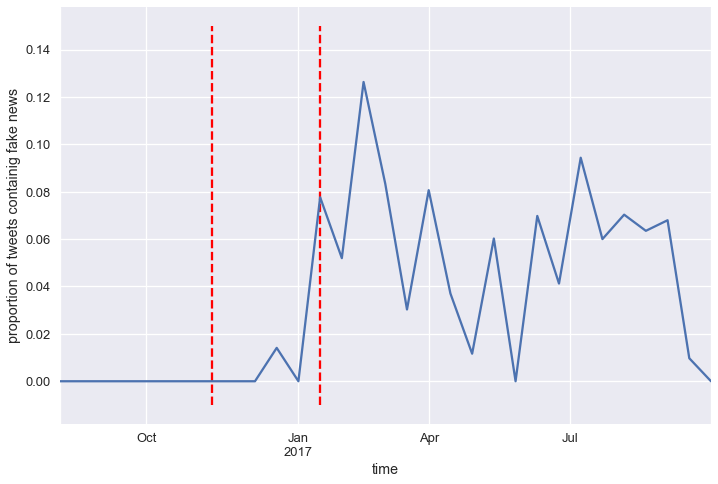

In [100]:
# Create your plot here...

fake_plot = fake_counts
fake_plot['proportion'] = fake_counts['fake_news']/fake_counts['total']
az = fake_plot.proportion.plot()
az.vlines([pd.to_datetime('11/08/2016'),pd.to_datetime('01/20/2017')], -.01, .15, linestyles = 'dashed', colors = 'R')
plt.xlabel('time')
plt.ylabel('proportion of tweets containig fake news')

# ...then write your takeaways here.
fake_news_answer = '''

The proportion of tweets using 'fake news' increased drastically in the time right before his inauguration and has
bounced up and down drastically in every period. This in part could be because these tweets do make up a very small
proportion of his overall tweets less than 15% even at their height. This could also be symbolic of Trump's mercurial
leadership style. Constantly keeping his fans guess. Happy one day. Angry the next. Keeping the emotions high. From
my experience DJ'ing I know that in order to keep a crowd going all night you have to keep things shifting: fast, slow,
loud, quiet, bass, treble. As an experienced entertainer it is no shock to me that Trump follows this same tenet with
his leadership style, always keeping his fans entertained and on their feet.


'''
display(Markdown(fake_news_answer))

## Submission

Congrats, you just finished Project 1!

Run the cell below to run all the OkPy tests at once:

In [101]:
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("ok_tests") if q.startswith('q')]

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t

Now, run the cell below to submit your assignment to OkPy. The autograder should email you shortly with your autograded score. The autograder will only run once every 30 minutes.

**If you're failing tests on the autograder but pass them locally**, you should simulate the autograder by doing the following:

1. In the top menu, click Kernel -> Restart and Run all.
2. Run the cell above to run each OkPy test.

**You must make sure that you pass all the tests when running steps 1 and 2 in order.** If you are still failing autograder tests, you should double check your results.

In [112]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 100% complete
Submission successful for user: mattholtzer9@berkeley.edu
URL: https://okpy.org/cal/ds100/fa17/proj1_part1/submissions/4xZM5x
NOTE: this is only a backup. To submit your assignment, use:
	python3 ok --submit

